-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
# Text Mining and Social Media Mining
## SEMESTRAL PROJECT - FAKE NEWS CLASSIFICATION
### Aleksandra Tomczak, Aleksander Partyga
-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
The aim of this project is to perform an analysis of fake and real pieces of news. For this purpose we used a dataset obtained from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?fbclid=IwAR00YQQQP3E-cjJsZ1jEPx-eyDoCYT2Vyu86043MWoZ9Fxxqj2necW8HZMY) which contains more than 21 thousands of real and more than 23 thousands of fake news that are mainly about US politics. After performing text preprocessing and exploratory data analysis, we will cluster the text in order to investigate any differences in the structure between the real articles and the fake ones.

In addition, after neatly preparing the data for the modelling process, we performed text classification with the use of logistic regression and multinomial naive bayes models. We compared the results of both models which turned out to be very satisfactory.

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

**The project consists of following sections:**

**Part 1** - Necessary imports and downloads.

**Part 2** - Text preprocessing and exploratory data analysis.

**Part 3** - Text clustering.

**Part 4** - News classiffication.

**Part 5** - Conclusions.

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### Part 1 - Necessary imports and downloads.

In [2]:
# General
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
from collections import Counter

# Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# Visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# Classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Function that will help us display pandas in a more compact way:

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style = "display:inline"'), raw = True)

Reading the data:

In [4]:
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

### Part 2 - Text preprocessing and exploratory data analysis.

Data contains two datasets, one with real news articles and one with fake ones. Our datasets have 4 columns of string type:

*title* - the title of the news,

*text* - the text of the article,

*subject* - the subject that the article is related to,

*date* - the date of the publication

#### Preprocessing

Let's take a look at the dataset.

In [5]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Firstly, we will check if the dataset is complete - if there are any NA.

In [6]:
# Checking for missing value
print(fake_news.isna().sum(), "\n\n", real_news.isna().sum())

title      0
text       0
subject    0
date       0
dtype: int64 

 title      0
text       0
subject    0
date       0
dtype: int64


There are no missing values in both datasets. We will drop *date* column, since we won't be using it in our analysis.

In [7]:
# Dropping unnecessary columns
fake_news.drop('date', inplace = True, axis = 1)
real_news.drop('date', inplace = True, axis = 1)

Next, we will take a look at the *subject* variable to see if it may be useful in further steps.

In [8]:
# Counting the number of articles in every subject
real_count = real_news.groupby(['subject']).count()
fake_count = fake_news.groupby(['subject']).count()

In [9]:
display_side_by_side(real_count, fake_count)

,title,text
subject,,
politicsNews,11272,11272
worldnews,10145,10145
,title,text
subject,,
Government News,1570,1570
Middle-east,778,778
News,9050,9050
US_News,783,783
left-news,4459,4459


As we can see, real news have only two subjects, so it will not be very useful. Fake news have more categories but since they are fake we will drop this variable as well.

In [10]:
# Dropping unnecessary columns
fake_news.drop('subject', inplace = True, axis = 1)
real_news.drop('subject', inplace = True, axis = 1)

In [11]:
real_news.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


It may be observed that the first two words of the real news text are not a part of the article - let's remove it. We will do that by splitting the text in two places: after the first word and after the second word. This will transform the string into a list of three elements: first word, second word and the rest of the text.

In [12]:
# Function removing the first two words of the article
def remove_cityname(_text):
    _list = _text.split(' ', 2)
    return _list[2]

The function above returned an error saying that the list index is out of range. That means that at least one of the strings in column *text* does not contain even 3 words. Let's check which rows have too short strings.

In [13]:
# Creating a copy of the data
real_news_copy = real_news.copy()

# Calculating the length of each article
real_news_copy['length'] = real_news_copy['text'].apply(len)

# Looking for the shortest one
min(real_news_copy['length'])

1

There is at least one observation that contains just one character. We will check if there is more of them.

In [14]:
# Sorting the articles from shortest to longest
real_news_copy.sort_values(by = 'length')

,title,text,length
8970,Graphic: Supreme Court roundup,,1
16059,Spain's cabinet to hold special meeting at 170...,MADRID (Reuters) - Spain s cabinet will hold a...,152
6131,White House: Trump speaks with Egypt's Sisi by...,WASHINGTON (Reuters) - U.S. President Donald T...,152
19359,UK PM May wants to be a strong friend to the EU,"FLORENCE, Italy (Reuters) - Britain wants to b...",156
20784,Russia's Putin says we will be able to solve t...,"VLADIVOSTOK, Russia (Reuters) - Russian Presid...",157
...,...,...,...
3319,Text: Ex-FBI Director Comey's prepared testimo...,(Reuters) - Following is the full text of form...,18541
8563,"The Big Squeeze: This election year, it’s all ...","MIDDLETOWN, CONN. - Two years ago, Judy Konopk...",18633
2594,Trump son-in-law Kushner's congressional state...,WASHINGTON (Reuters) - I am voluntarily provid...,21559
8465,"Disillusionment, U.S.A. Where voters are just ...","ALGONAC, MICH.—Parker Fox drifted out of the D...",21661


Fortunately, just one row happened to contain an invalid text, so now we will drop it from original dataset.

In [15]:
# Removing the invalid row
real_news = real_news.drop([8970])

In [16]:
# Removing first two words from the text of the articles
real_news['text'] = real_news['text'].apply(remove_cityname)

In [17]:
real_news.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",- The head of a conservative Republican factio...
1,U.S. military to accept transgender recruits o...,- Transgender people will be allowed for the f...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,- The special counsel investigation of links b...
3,FBI Russia probe helped by Australian diplomat...,- Trump campaign adviser George Papadopoulos t...
4,Trump wants Postal Service to charge 'much mor...,- President Donald Trump called on the U.S. Po...


Now, we can start processing the text. The first step is to transform all the characters into lower form.

In [18]:
# Trasforming all characters to lower
real_news['title_processed'] = real_news['title'].map(lambda x: x.lower())
real_news['text_processed'] = real_news['text'].map(lambda x: x.lower())

fake_news['title_processed'] = fake_news['title'].map(lambda x: x.lower())
fake_news['text_processed'] = fake_news['text'].map(lambda x: x.lower())

In [19]:
fake_news.head()

,title,text,title_processed,text_processed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,donald trump sends out embarrassing new year’...,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",sheriff david clarke becomes an internet joke...,"on friday, it was revealed that former milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",trump is so obsessed he even has obama’s name...,"on christmas day, donald trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...


To remove stopwords we have to use RegEx, otherwise it takes too long to go through 20k+ strings.

In [20]:
# RegEx expression to remove stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

In [21]:
# Function removing English stopwords
def remove_stopwords(_text):
    _text = pattern.sub('', _text)
    return _text

In [22]:
# Removing stopwords from fake news
fake_news['title_processed'] = fake_news['title_processed'].apply(remove_stopwords)
fake_news['text_processed'] = fake_news['text_processed'].apply(remove_stopwords)

In [23]:
# Removing stopwords from real news
real_news['title_processed'] = real_news['title_processed'].apply(remove_stopwords)
real_news['text_processed'] = real_news['text_processed'].apply(remove_stopwords)

In [24]:
fake_news.head()

,title,text,title_processed,text_processed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,donald trump sends embarrassing new year’eve ...,donald trump wish americans happy new year lea...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",sheriff david clarke becomes internet joke th...,"friday, revealed former milwaukee sheriff davi..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",trump obsessed even obama’name coded website ...,"christmas day, donald trump announced would b..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,pope francis called donald trump christmas sp...,pope francis used annual christmas day message...


Next step is to remove all non-ASCII characters that may occur in text. Later all numbers, links and punctuation is removed.

In [25]:
# Function removing non-ASCII characters
def remove_nonascii(_text):
    return _text.encode('ascii', 'ignore').decode('ascii')

In [26]:
# Removing non-ASCII characters from fake news
fake_news['title_processed'] = fake_news['title_processed'].apply(remove_nonascii)
fake_news['text_processed'] = fake_news['text_processed'].apply(remove_nonascii)

In [27]:
# Removing non-ASCII characters from real news
real_news['title_processed'] = real_news['title_processed'].apply(remove_nonascii)
real_news['text_processed'] = real_news['text_processed'].apply(remove_nonascii)

In [28]:
# Function removing different types of links
def remove_links(_text):
    _text = re.sub('([0-9]+)', '', _text)
    _text = re.sub(r'http\S+', '', _text)
    _text = re.sub(r'bit.ly/\S+', '', _text)
    _text = _text.strip('[link]')
    _text = re.sub('[%s]' % re.escape(string.punctuation), '', _text)
    return _text

In [29]:
# Removing links from processed text
fake_news['title_processed'] = fake_news['title_processed'].apply(remove_links)
fake_news['text_processed'] = fake_news['text_processed'].apply(remove_links)

real_news['title_processed'] = real_news['title_processed'].apply(remove_links)
real_news['text_processed'] = real_news['text_processed'].apply(remove_links)

In [32]:
real_news.head()

,title,text,title_processed,text_processed
0,"As U.S. budget fight looms, Republicans flip t...",- The head of a conservative Republican factio...,u budget fight looms republicans flip fiscal s...,head conservative republican faction u congre...
1,U.S. military to accept transgender recruits o...,- Transgender people will be allowed for the f...,u military accept transgender recruits monday ...,transgender people allowed first time enlist ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,- The special counsel investigation of links b...,senior u republican senator let mr mueller job,special counsel investigation links russia pr...
3,FBI Russia probe helped by Australian diplomat...,- Trump campaign adviser George Papadopoulos t...,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos to...
4,Trump wants Postal Service to charge 'much mor...,- President Donald Trump called on the U.S. Po...,trump wants postal service charge much amazon...,president donald trump called u postal servic...


#### Most common words

To compare the content of both datasets we will extract most commonly used words in both. The first step is to join all the articles into one long string and split into the list of all words.

In [33]:
# Joining the text of articles into one long string
real_words = ' '.join(real_news['text_processed'])
fake_words = ' '.join(fake_news['text_processed'])

In [34]:
fake_words[:1000]

'donald trump wish americans happy new year leave  instead give shout enemies haters dishonest fake news media  former reality show star one job  country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year  president angry pants tweeted   great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year  great year america  donald j trump realdonaldtrump december  trump tweet went welll expectkind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year  bishop talbert swan talbertswan december  no one likes calvin calvinstowell december  your impeachment would make  great year america also accept regaining control congress  miranda yaver mirandayaver december  do hear talk include many people hate wonder hate   

In [35]:
# Splitting the strings into lists of words
real_words = real_words.split()
fake_words = fake_words.split()

To count how many times a word occured in the list we will use a function *Counter* imported from *collections* library. It returns a list of tuples (word, frequency) sorted in a descending order of the frequency.

In [36]:
# Counting how many times each word occured in a list
counter_real = Counter(real_words)
counter_fake = Counter(fake_words)

In [37]:
# Getting top 20 most commonly used words
mostcommon_real = counter_real.most_common(20)
mostcommon_fake = counter_fake.most_common(20)

In [38]:
mostcommon_real

[('said', 98927),
 ('trump', 42729),
 ('u', 38348),
 ('would', 31493),
 ('president', 25498),
 ('state', 18675),
 ('government', 17725),
 ('states', 16618),
 ('house', 16375),
 ('also', 15930),
 ('new', 15678),
 ('united', 15360),
 ('people', 15099),
 ('republican', 14963),
 ('told', 14237),
 ('could', 13686),
 ('one', 12683),
 ('last', 12548),
 ('election', 11610),
 ('two', 11530)]

The letter 'u' is probably abbreviation, it does not bring any value to the analysis, so we will drop it from our list.

In [39]:
# Dropping the word 'u' from the list
mostcommon_real = counter_real.most_common(21)
mostcommon_real.pop(2)

('u', 38348)

In [40]:
# Converting lists of tuples into data frames
df_real = pd.DataFrame(mostcommon_real, columns = ['word', 'frequency'])
df_fake = pd.DataFrame(mostcommon_fake, columns = ['word', 'frequency'])

In [41]:
display_side_by_side(df_real, df_fake)

,word,frequency
0,said,98927
1,trump,42729
2,would,31493
3,president,25498
4,state,18675
5,government,17725
6,states,16618
7,house,16375
8,also,15930
9,new,15678


As we can observe, the lists are quite similar - they both contain words associated with politics and the two most popular words are the same (in a different order). Having so similar content means that the datasets are well prepared and it is not that trivial to classify the news. It may be worth to take a look at titles as well:

In [42]:
# Joining the text of articles into one long string
real_titles = ' '.join(real_news['title_processed'])
fake_titles = ' '.join(fake_news['title_processed'])

# Splitting the strings into lists of words
real_titles = real_titles.split()
fake_titles = fake_titles.split()

# Counting how many times each word occured in a list
counter_realtitles = Counter(real_titles)
counter_faketitles = Counter(fake_titles)

# Here we also had to pop the letter 'u'
mostcommon_realtitles = counter_realtitles.most_common(11)
mostcommon_faketitles = counter_faketitles.most_common(10)
mostcommon_realtitles.pop(1)

# Converting lists of tuples into data frames
df_realtitles = pd.DataFrame(mostcommon_realtitles, columns = ['word', 'frequency'])
df_faketitles = pd.DataFrame(mostcommon_faketitles, columns = ['word', 'frequency'])

In [43]:
display_side_by_side(df_realtitles, df_faketitles)

,word,frequency
0,trump,4741
1,says,2980
2,house,1436
3,korea,804
4,white,803
5,russia,790
6,north,777
7,senate,733
8,court,704
9,new,645


With no suprise, words occuring most often in the titles are connected to similar topics as words in articles. The most common word in fake news titles is 'video' which is an understandable clickbait tactic.

#### Bigrams

We wanted to also check what pairs of words, called bigrams, occur most often in the articles. There is not much conclusion to be drawn from single words, pairings however, may give us some overview about the context the word was used in.

To create a list of pairs we zipped the list with itself shifted by one element:

In [44]:
# Zipping the list with itself shifted by one word
bigrams_real = zip(real_words, real_words[1:])
bigrams_fake = zip(fake_words, fake_words[1:])

In [45]:
# Counting how many times each bigram occured in a list
bicounter_real = Counter(bigrams_real)
bicounter_fake = Counter(bigrams_fake)

# Getting top 15 most commonly used bigrams
common_bigrams_real = bicounter_real.most_common(15)
common_bigrams_fake = bicounter_fake.most_common(15)

# Converting lists into data frames
df_bigrams_real = pd.DataFrame(common_bigrams_real, columns = ['bigrams', 'frequency'])
df_bigrams_fake = pd.DataFrame(common_bigrams_fake, columns = ['bigrams', 'frequency'])

In [46]:
display_side_by_side(df_bigrams_real, df_bigrams_fake)

,bigrams,frequency
0,"(united, states)",12174
1,"(white, house)",8183
2,"(donald, trump)",8006
3,"(president, donald)",5912
4,"(north, korea)",5281
5,"(prime, minister)",4099
6,"(said, statement)",3918
7,"(new, york)",3563
8,"(told, reuters)",3491
9,"(trump, said)",3462


Result differs a bit from what we expected. Two most common words 'trump' and 'said' are at 9th place in real articles, but they did not make even the top 15 in fake ones. The rest of the bigrams are connected with articles subject, just like words they are mostly politically related.

### Part 3 - Text clustering.

Text clustering is to automatically group textual documents (for example, documents in plain text, web pages, emails and etc) into clusters based on their content similarity. 

#### TF-IDF Vectorization

The TF-IDF converts our corpus into a numerical format by bringing out specific terms, weighing very rare or very common terms differently in order to assign them a low score.
TF stands for term frequency, while IDF stands for inverse document frequency. The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain that word.

In [47]:
# Initializing the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = 5, max_df = 0.95)

# Applying TF-IDF to processed text
x_real = vectorizer.fit_transform(real_news['text_processed'])
x_fake = vectorizer.fit_transform(fake_news['text_processed'])

#### Implementation of k-means

Firstly, we will look for an optimal number of clusters. In order to do that, we will use function that was introduced during our classes.

In [50]:
# Function for finding the optimal number of clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters = k, init_size = 1024, batch_size = 2048, random_state = 20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

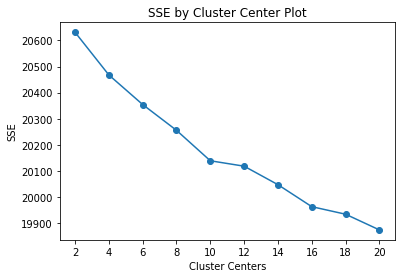

In [51]:
find_optimal_clusters(x_real, 20)

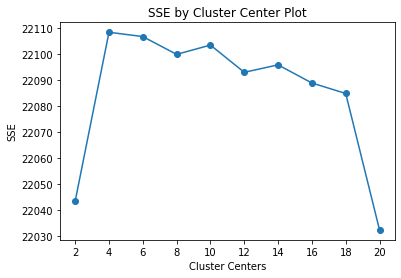

In [52]:
find_optimal_clusters(x_fake, 20)

We will set the number of cluster for real news at k = 10 and for fake news k = 8 and k = 2.

Real news clustering:

In [53]:
# Initializing kmeans with 10 centroids
kmeans_real = KMeans(n_clusters = 10, random_state = 42)

# Fitting the models
kmeans_real.fit(x_real)

# Storing cluster labels in a variable
clusters_real = kmeans_real.labels_

Fake news clustering:

In [54]:
# Initializing kmeans with 8 centroids
kmeans_fake = KMeans(n_clusters = 8, random_state = 42)

# Fitting the models
kmeans_fake.fit(x_fake)

# Storing cluster labels in a variable
clusters_fake = kmeans_fake.labels_

In [55]:
# Initializing kmeans with 2 centroids
kmeans_fake2 = KMeans(n_clusters = 2, random_state = 42)

# Fitting the models
kmeans_fake2.fit(x_fake)

# Storing cluster labels in a variable
clusters_fake2 = kmeans_fake2.labels_

#### PCA and vizualization

In order to visualize the clusters we need to reduce dimensions. Since we are clustering text, the number of dimensions is relatively high. We will reduce the number to 3, to perform the 3D vizualization.

In [56]:
# Initializing PCA with 3 components
pca = PCA(n_components = 3, random_state = 42)

In [57]:
# Passing our vectorized data to the PCA and storing the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(x_real.toarray())

# Saving three dimensions
x0_real = pca_vecs[:, 0]
x1_real = pca_vecs[:, 1]
x2_real = pca_vecs[:, 2]

Now, we will add the information about the clusters and dimensions to our data set:

In [58]:
# Appending new columns
real_news['cluster'] = clusters_real
real_news['x0'] = x0_real
real_news['x1'] = x1_real
real_news['x2'] = x2_real

Repeating the whole procuder for the fake news:

In [59]:
# Passing our vectorized data to the PCA and storing the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(x_fake.toarray())

# Saving three dimensions
x0_fake = pca_vecs[:, 0]
x1_fake = pca_vecs[:, 1]
x2_fake = pca_vecs[:, 2]

In [61]:
# Appending new columns
fake_news['cluster'] = clusters_fake
fake_news['cluster2'] = clusters_fake2
fake_news['x0'] = x0_fake
fake_news['x1'] = x1_fake
fake_news['x2'] = x2_fake

Plotting the output:

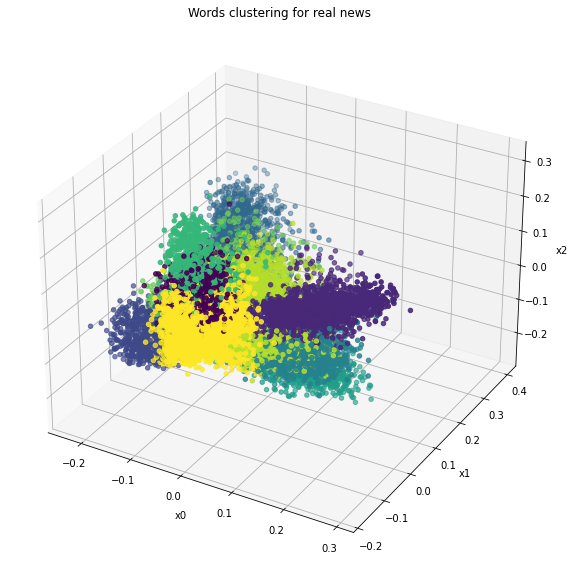

In [74]:
# Clustering for real news
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_news['x0'], real_news['x1'], real_news['x2'], c = real_news['cluster'])
ax.set_title("Words clustering for real news")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")
plt.show()

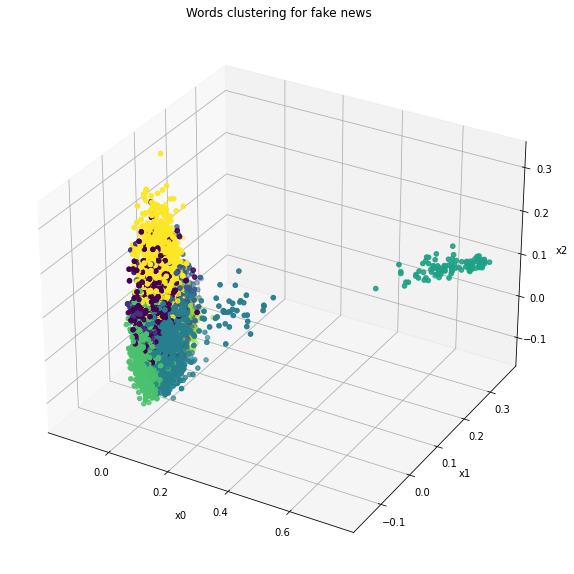

In [72]:
# Clustering for fake news - 8 clusters
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fake_news['x0'], fake_news['x1'], fake_news['x2'], c = fake_news['cluster'])
ax.set_title("Words clustering for fake news")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")
plt.show()

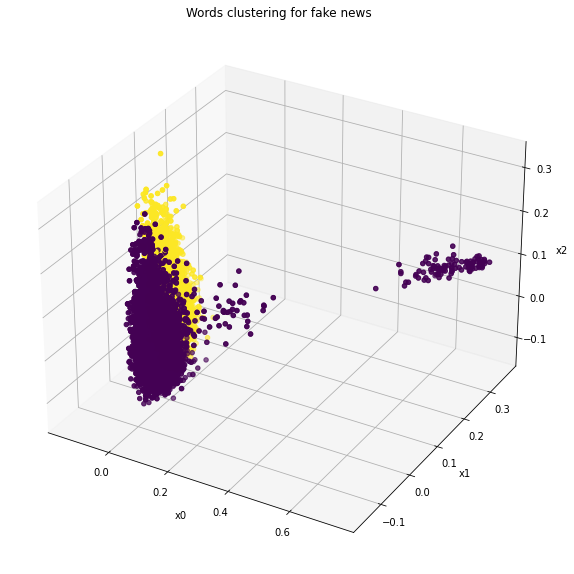

In [73]:
# Clustering for fake news - 2 clusters
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fake_news['x0'], fake_news['x1'], fake_news['x2'], c = fake_news['cluster2'])
ax.set_title("Words clustering for fake news")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")
plt.show()

The difference in the structure for the fake and real news is clearly visible. To further analyze the clusters we will use slightly modified version of the function from [GitHub](https://gist.github.com/andrea-dagostino/ef81c60ff93fd455e0a666f17b0bbb72#file-clustering_eng_get_top_keywords-py) that returnes top keywords for each cluster.

In [91]:
def get_top_keywords(n, df_vec, clusters):
    df = pd.DataFrame(df_vec.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([terms[t] for t in np.argsort(r)[-n:]]))

In [87]:
get_top_keywords(15, x_real, clusters_real)


Cluster 0
distractions, adversity, distracts, repstevensmith, closes, east, masks, faltering, pup, chances, amy, exhorted, caingetty, existed, ipt

Cluster 1
saidhowever, couples, outcry, clintonemail, flanked, pga, spoiled, lifethreatening, outlandish, outlines, humane, fraudster, pondering, residential, bechtel

Cluster 2
approved, repel, repeated, herd, pausing, guests, jacksonville, guestworker, jacqueline, pga, kissed, ramin, hiroshima, energizing, gupta

Cluster 3
saidhowever, hammer, revelations, seize, severed, pga, phrase, publishing, capabilities, newfound, jesus, levi, hilarieburton, lejeune, hijrah

Cluster 4
physicist, defect, nightly, slated, lease, pga, determine, countryu, breathtaking, brice, fooling, morton, outlandish, saidhowever, celebratory

Cluster 5
cyber, cheeseburger, morningmika, fraudster, breathtaking, pga, chided, ground, choking, determine, earpiece, saidhowever, periscope, grams, perpetrator

Cluster 6
sedition, contradicts, pga, repstevensmith, mr, gui

In [82]:
get_top_keywords(15, x_fake, clusters_fake)


Cluster 0
war, state, terrorist, president, military, isis, said, states, refugees, islamic, syria, united, obama, us, muslim

Cluster 1
law, senate, government, trump, federal, health, president, state, court, said, bill, obama, people, republicans, would

Cluster 2
president, voters, said, donald, candidate, presidential, party, sanders, vote, democratic, election, campaign, trump, hillary, clinton

Cluster 3
great, said, us, one, america, video, people, century, st, watch, president, news, obama, wire, trump

Cluster 4
savants, evangelists, masochists, mediamaniacs, pst, hesher, alternate, animals, tune, radio, broadcast, room, pm, acr, boiler

Cluster 5
white, shooting, told, video, officer, lives, school, man, one, gun, people, officers, said, black, police

Cluster 6
republican, going, know, even, white, via, would, image, one, like, said, people, president, donald, trump

Cluster 7
said, hillary, former, emails, president, director, information, clinton, intelligence, comey, in

In [83]:
get_top_keywords(15, x_fake, clusters_fake2)


Cluster 0
black, new, also, like, us, president, news, trump, state, would, obama, police, one, people, said

Cluster 1
via, even, image, republican, campaign, one, like, hillary, clinton, would, people, said, president, donald, trump


Function *todense()* returns a dense matrix representation of the matrix. When we ran *get_top_keywords* function on real data multiple times, every time the result was a bit different. Running this function multiple times for the fake news returned almost identical key words, meaning that the variety of used words is smaller.

### Part 4 - News classification.

We create a variable named "target" in which real news are labeled as 1 and fake news as 0. This is a necessary step for in order to perform classification on those texts.

In [37]:
real_news['target'] = 1
fake_news['target'] = 0
mixed_news = pd.concat([real_news, fake_news]).reset_index(drop = True)

In [38]:
mixed_news

,title,text,title_processed,text_processed,target
0,"As U.S. budget fight looms, Republicans flip t...",- The head of a conservative Republican factio...,u budget fight looms republicans flip fiscal s...,head conservative republican faction u congre...,1
1,U.S. military to accept transgender recruits o...,- Transgender people will be allowed for the f...,u military accept transgender recruits monday ...,transgender people allowed first time enlist ...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,- The special counsel investigation of links b...,senior u republican senator let mr mueller job,special counsel investigation links russia pr...,1
3,FBI Russia probe helped by Australian diplomat...,- Trump campaign adviser George Papadopoulos t...,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,- President Donald Trump called on the U.S. Po...,trump wants postal service charge much amazon...,president donald trump called u postal servic...,1
...,...,...,...,...,...
44892,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,mcpain john mccain furious iran treated us sai...,st century wire says wire reported earlier wee...,0
44893,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,justice yahoo settles email privacy classactio...,st century wire says familiar theme whenever d...,0
44894,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,sunnistan us allied safe zone plan take territ...,patrick henningsen st century wireremember ob...,0
44895,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,blow million al jazeera america finally calls...,st century wire says al jazeera america go his...,0


We subset the dataframe for only those columns that will be needed in modelling process:

In [39]:
mixed_news = mixed_news[['title_processed', 'text_processed', 'target']]
mixed_news

,title_processed,text_processed,target
0,u budget fight looms republicans flip fiscal s...,head conservative republican faction u congre...,1
1,u military accept transgender recruits monday ...,transgender people allowed first time enlist ...,1
2,senior u republican senator let mr mueller job,special counsel investigation links russia pr...,1
3,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos to...,1
4,trump wants postal service charge much amazon...,president donald trump called u postal servic...,1
...,...,...,...
44892,mcpain john mccain furious iran treated us sai...,st century wire says wire reported earlier wee...,0
44893,justice yahoo settles email privacy classactio...,st century wire says familiar theme whenever d...,0
44894,sunnistan us allied safe zone plan take territ...,patrick henningsen st century wireremember ob...,0
44895,blow million al jazeera america finally calls...,st century wire says al jazeera america go his...,0


Splitting observations into training and testing sample

In [40]:
X_train, X_test, y_train, y_test = train_test_split(mixed_news.text_processed, mixed_news.target,
                                                    test_size = 0.2, random_state = 13)

In [41]:
y_train.value_counts('y')

0    0.522594
1    0.477406
Name: target, dtype: float64

In [42]:
y_test.value_counts('y')

0    0.52461
1    0.47539
Name: target, dtype: float64

The proportions of x and y classes in both samples are very similar. Next step is to convert a collection of text documents to a matrix of token counts with the use of CountVectorizer() function

In [43]:
count_vect = CountVectorizer().fit(X_train)
X_count_vect_train = count_vect.transform(X_train)
X_count_vect_test = count_vect.transform(X_test)

We obtain a sparse matrix of the counts.

In [44]:
X_count_vect_train

<35917x207259 sparse matrix of type '<class 'numpy.int64'>'
	with 5734989 stored elements in Compressed Sparse Row format>

#### Logistic Regression

In [45]:
lr = LogisticRegression()

lr_fitted = lr.fit(X_count_vect_train, y_train)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
lr_fitted

LogisticRegression()

In [47]:
# Let's make predictions with logistic regression model
lr_predictions = lr.predict(X_count_vect_test)

<AxesSubplot:>

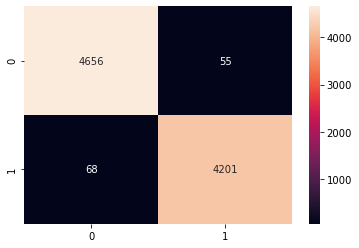

In [48]:
# Checking how accurate the predicitons were on the confusion matrix
cm = confusion_matrix(list(y_test), lr_predictions)
plt.figure()
sns.heatmap(cm, annot = True, fmt = 'g', cmap='rocket')

In [49]:
# Now let's see this prediction on a joint metric - the Area Under the ROC Curve (AUC)
lr_ac = accuracy_score(y_test, lr_predictions)
print(f'The logistic regression model accurately classified real and fake news in \033[1m{round(lr_ac, 3)*100}%\033[0m of cases')

The logistic regression model accurately classified real and fake news in 98.6% of cases


The obtained accuracy is very high. Let's see whether another model can beat this value

#### Multinomial Naive Bayes

In [51]:
mnb = MultinomialNB()
mnb_fitted = mnb.fit(X_count_vect_train, y_train)

In [52]:
# Let's make predictions with logistic regression model
mnb_predictions = mnb.predict(X_count_vect_test)

<AxesSubplot:>

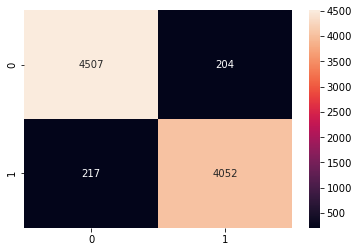

In [53]:
# Checking how accurate the predicitons were on the confusion matrix
cm = confusion_matrix(list(y_test), mnb_predictions)
plt.figure()
sns.heatmap(cm, annot = True, fmt = 'g', cmap='rocket')

In [55]:
# Now let's see this prediction on a joint metric - the Area Under the ROC Curve (AUC)
mnb_ac = accuracy_score(y_test, mnb_predictions)
print(f'The multinomial naive bayes model accurately classified real and fake news in \033[1m{round(mnb_ac, 3)*100}%\033[0m of cases')

The multinomial naive bayes model accurately classified real and fake news in 95.3% of cases


### Part 5 - Conclusions.

At first glance both sets seemed very similar - the top words returned for both sets were almost interchangeable and both contained words associated with politics. The news are from the year 2017, so we can see that words resemble the American (USA) political scene at the moment.

After running clustering and plotting the results it could be clearly noticed that the word structure of fake articles differs from the real ones. In the real news there are naturally formed clusters that can be quite easily determined. Fake news clusters are concentrated very densly in one spot, meaning the points have similar coordinates. This is also reflected in a key word extraction - if we compare the results for key words for 2 or 8 clusters, we can see that there is not much variety in those words. It is really hard to distinguish different subjects, even though at the beginning of our analysis we could see that fake news have more subject categories than the real ones.

For the classification part, obtaining very high accuracy (more than 98 % in case of logistic regression) can lead to the conclusion that this model distinguishes real and fake news (about US politics) very well. Nowadays, it is invaluable to be able to know whether an information on the social media can be trusted. With this simple example model we proven that more sophisticated models  (trained on a much bigger sample and wider range of topics) could provide us certainty whether the content of the news that we read every single day can be trusted or not.